In [1]:
import numpy as np
import networkx as nx
import cvxpy as cp
from numpy.random import choice, rand 
from tqdm import tqdm
import matplotlib.pyplot as plt

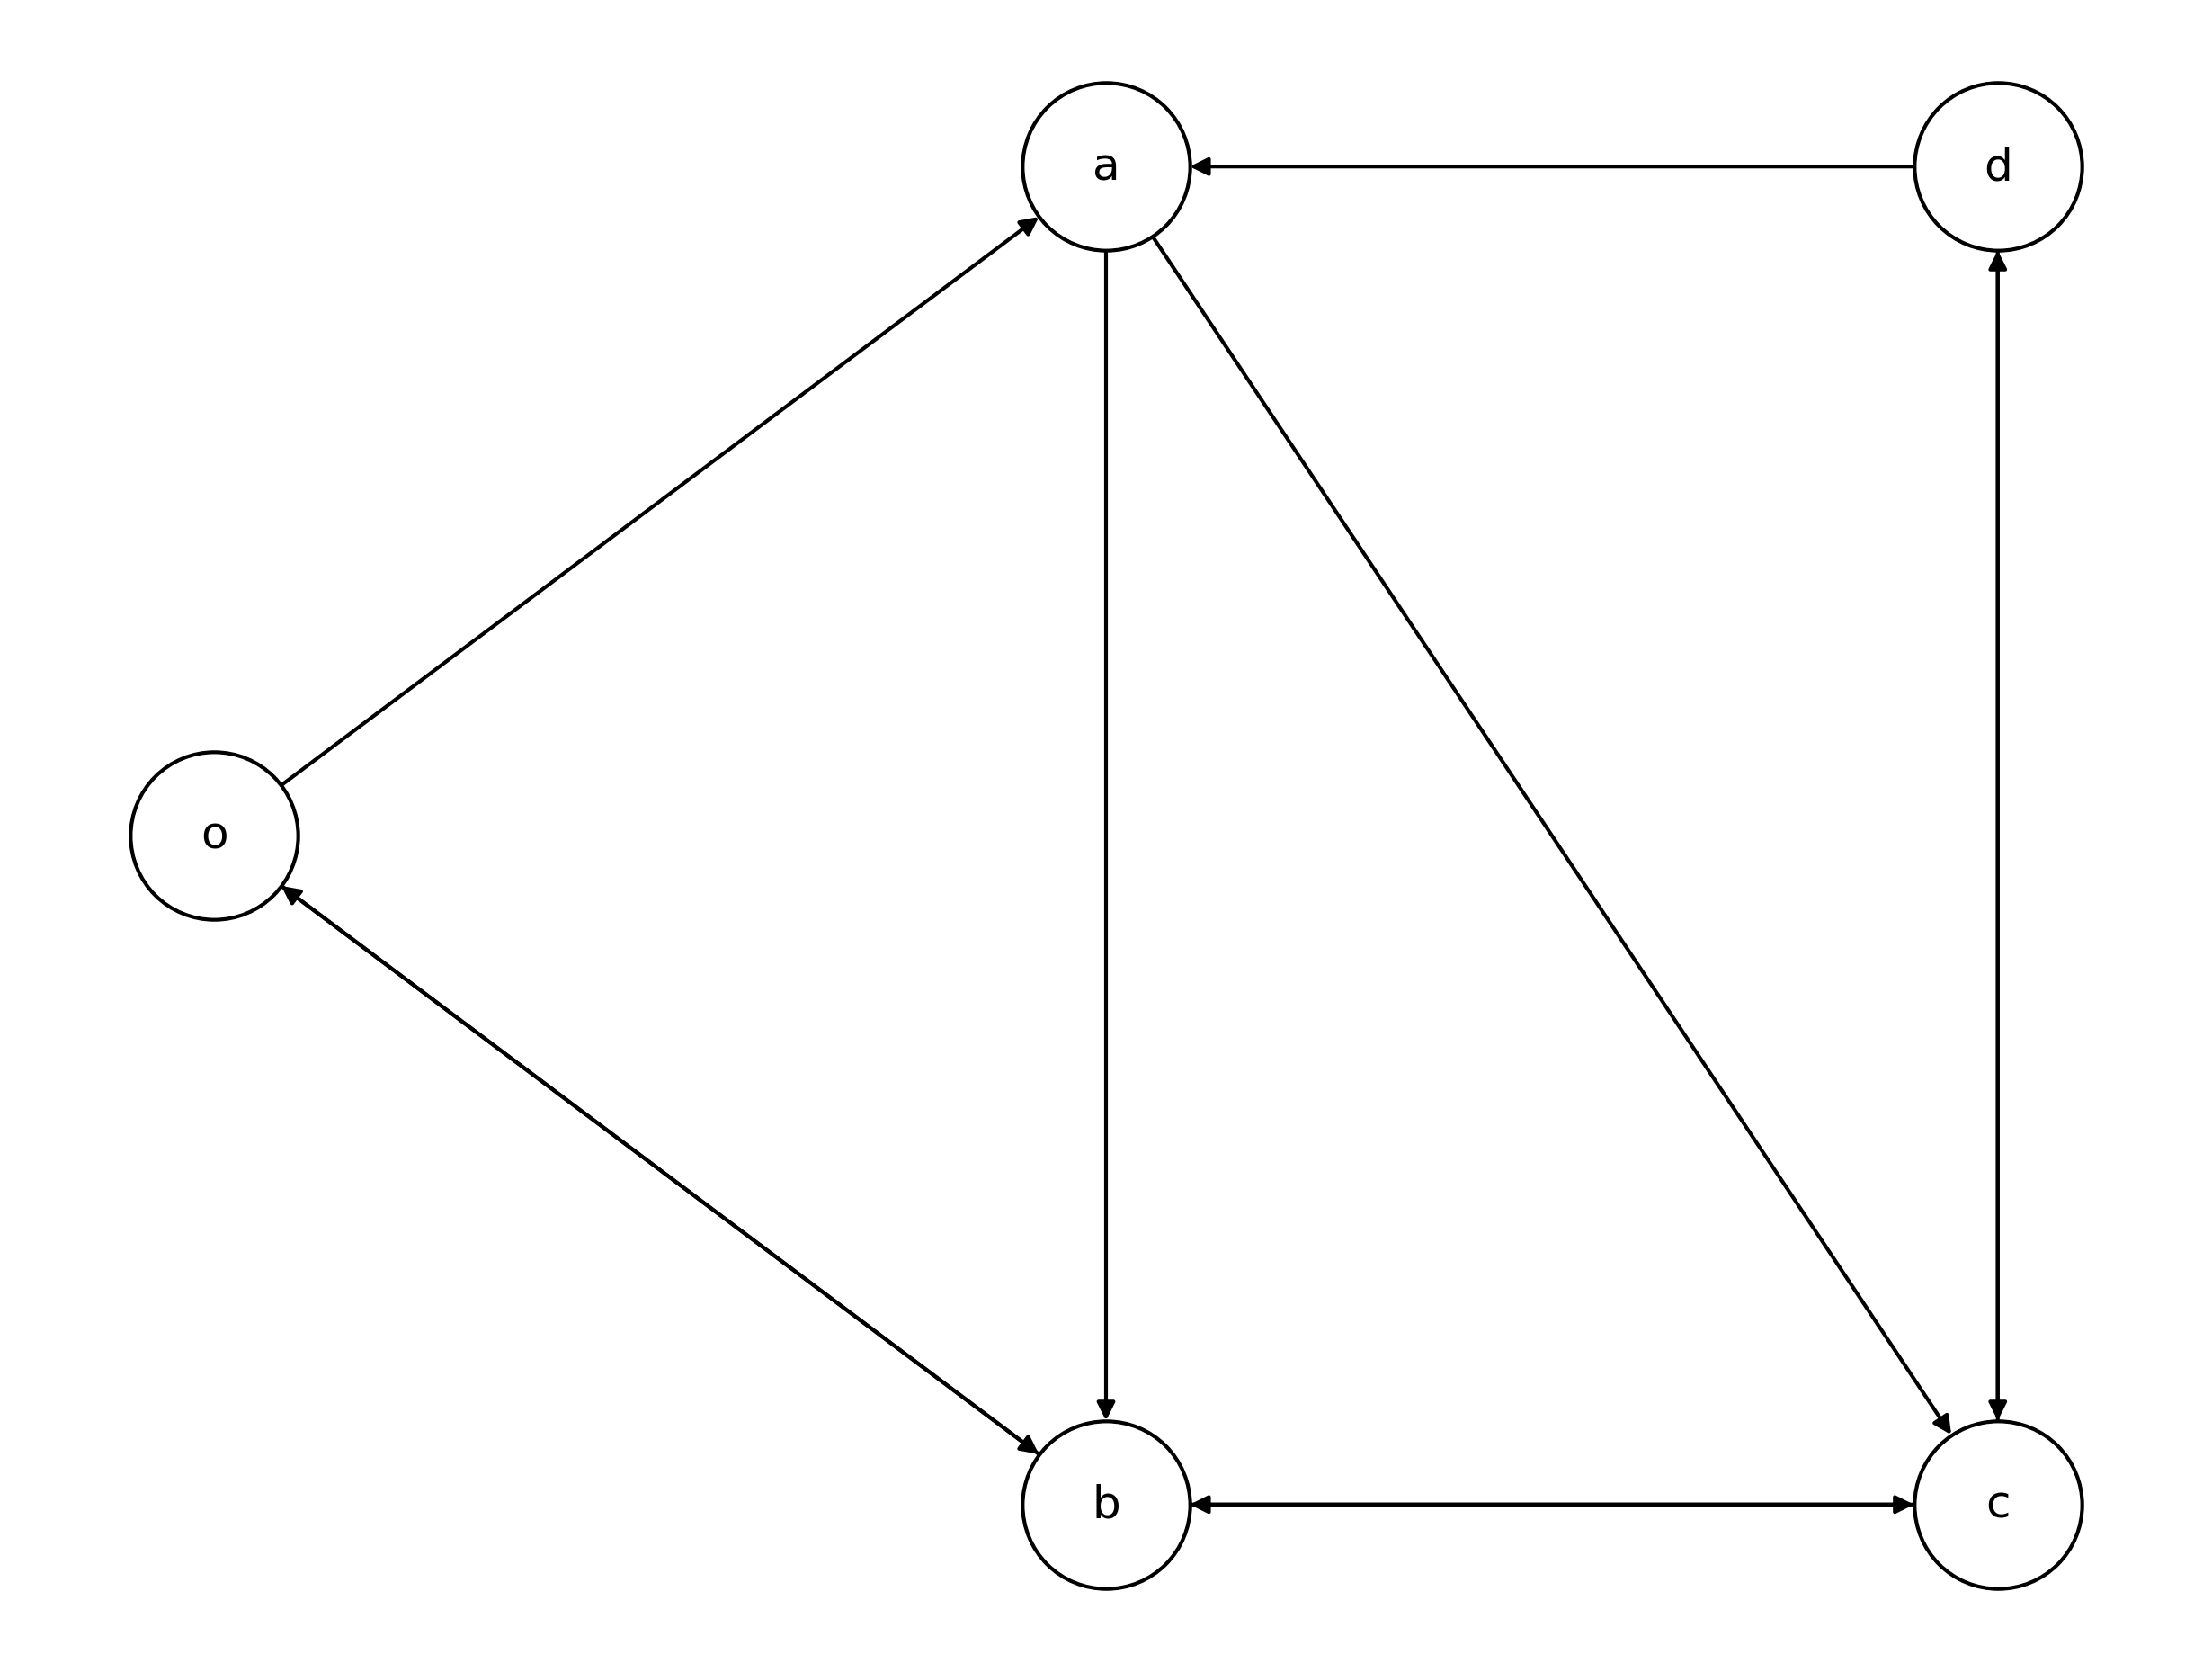

In [2]:
t_rate = np.array([
        [0, 2/5, 1/5, 0, 0],
        [0, 0, 3/4, 1/4, 0],
        [1/2, 0, 0, 1/3, 0],
        [0, 0, 1/3, 0, 2/3],
        [0, 1/3, 0, 1/3, 0]
    ])
nodes = ["o", "a", "b", "c", "d"]
node_index = {
    node: idx for idx, node in enumerate(nodes)
}
G = nx.DiGraph()
G.add_nodes_from(nodes)
for i in G.nodes:
    for j in G.nodes:
        if node_index[i] != node_index[j] and t_rate[node_index[i], node_index[j]] > 0:
            G.add_edge(i, j, rate=t_rate[node_index[i], node_index[j]])
pos = {"o":(0,0), "a":(1,1), "b":(1,-1), "c":(2,-1), "d":(2,1)}

plt.figure(figsize=(8, 6), dpi=300) 

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="white",edgecolors='black',  edge_color="black")
plt.savefig('plots/ex1_1.png')

plt.show()

# (a) What is, according to the simulations, the average time it takes a particle that starts in node b to leave the node and then return to it?

Function that from the adj nodes compute the time $t_{next}$ 

In [3]:
def t_next(rate):
    return -np.log(np.random.uniform(0, 1))/rate
# from G.adj -> next x with t_time

def choose(adj):
    nodes_time_tick = {}
    for n, r in adj.items():
        nodes_time_tick[n] = t_next(r['rate'])
    node = min(nodes_time_tick, key=nodes_time_tick.get)
    time = nodes_time_tick[node]
    return node, time 

 #example 
adj = G.adj['b']
print(choose(adj))

('o', 0.28727053403583463)


In [4]:
# Simulates a random walk on the graph G, starting from node xi.
# if till_first_return = True the random walk stops the first time
# it returns to the starting node xi.
# Otherwise, it goes on for num_steps steps.

def RandomWalk(G, xi,xd, num_steps, till_first_return = False):
    nodeSeq = []
    nodeSeq.append(xi)
    times = []
    if till_first_return:
        x_init = xi
        
        while True:
            xi, time = choose(G.adj[xi])     
            nodeSeq.append(xi)
            times.append(time)
            
            if xi == xd:
                return nodeSeq, times
    
    else:
        for i in range(num_steps):
            xi = choice(G.adj[xi],1)[0]      
            nodeSeq.append(xi)
        return nodeSeq, times

In [5]:
n_simulations = int(5e4)
starting_node = 'b'
durations = np.zeros(n_simulations)
for simulation in tqdm(range(n_simulations)):
    _, times = RandomWalk(G=G, xi=starting_node,xd=starting_node,num_steps=0,till_first_return=True)
    durations[simulation] = sum(times)

print(f"Average (empirical) Return Time from node '{starting_node}' : {durations.mean():.2f} t.u.")

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:01<00:00, 31502.95it/s]

Average (empirical) Return Time from node 'b' : 4.62 t.u.


# (b) How does the result in a) compare to the theoretical return-time Eb[Tb+]? (Include a description of how this is computed.)

In [6]:
transition_matrix = np.array([
                [0, 2/5, 1/5, 0, 0],
                [0, 0, 3/4, 1/4, 0],
                [1/2, 0, 0, 1/3, 0],
                [0, 0, 1/3, 0, 2/3],
                [0, 1/3, 0, 1/3, 0]
            ])
omega = np.sum(transition_matrix, axis=1)
print(f'omega: {omega}')
diagonal = np.diag(omega)
L = diagonal - transition_matrix
L = L.T

invariant = cp.Variable(len(G.nodes()))
objective = cp.Minimize(0)
constraints = [L @ invariant == 0, cp.sum(invariant)==1]
prob_w = cp.Problem(objective, constraints)

result_w = prob_w.solve(solver=cp.ECOS)
invariant_bar = invariant.value
print("pi bar: ", invariant_bar)
expected_time = 1/(invariant_bar[node_index['b']]* omega[node_index['b']])
print(f"Expected Time: {expected_time:.2f}")


omega: [0.6        1.         0.83333333 1.         0.66666667]
pi bar:  [0.2173913  0.14906832 0.26086957 0.1863354  0.1863354 ]
Expected Time: 4.60


# c) What is, according to the simulations, the average time it takes to move from node o to node d?

In [7]:
n_simulations = int(5e4)
starting_node = 'o'
destination_node = 'd'

durations = np.zeros(n_simulations)
for simulation in tqdm(range(n_simulations)):
    _, times = RandomWalk(G=G, xi=starting_node,xd=destination_node,num_steps=0,till_first_return=True)
    durations[simulation] = sum(times)

print(f"Average (empirical) Return Time from node '{starting_node}' to node {destination_node}: {durations.mean():.2f} t.u.")


100%|██████████| 50000/50000 [00:03<00:00, 14418.21it/s]

Average (empirical) Return Time from node 'o' to node d: 10.81 t.u.


# (d) How does the result in c) compare to the theoretical hitting-time Eo[Td]? (Describe also howthis is computed.)

In [8]:
t_rate = np.array([
        [0, 2/5, 1/5, 0, 0],
        [0, 0, 3/4, 1/4, 0],
        [1/2, 0, 0, 1/3, 0],
        [0, 0, 1/3, 0, 2/3],
        [0, 1/3, 0, 1/3, 0]
    ])
omega = np.sum(transition_matrix, axis=1).reshape((5,1))
P = t_rate/omega

P_bar = np.delete(P, node_index[destination_node],axis=0)
P_bar = np.delete(P_bar, node_index[destination_node],axis=1)

tau = cp.Variable(len(G.nodes())- 1)

objective = cp.Minimize(0)
constraints = [tau.reshape((4,1)) - 1/omega[:-1] - P_bar @ tau.reshape((4,1)) == 0]
prob_w = cp.Problem(objective, constraints)

result_w = prob_w.solve(solver=cp.ECOS)
tau_bar = tau.value
print("tau bar: ", tau_bar)


tau bar:  [10.76666667  9.          9.3         4.1       ]


# (e) Interpret the matrix Λ as the weight matrix of a graph G = (V,E,Λ), and simulate the French- DeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge to a consensus state for every initial condition x(0)? Motivate your answer.

In [9]:
t_rate = np.array([
        [0, 2/5, 1/5, 0, 0],
        [0, 0, 3/4, 1/4, 0],
        [1/2, 0, 0, 1/3, 0],
        [0, 0, 1/3, 0, 2/3],
        [0, 1/3, 0, 1/3, 0]
    ])
nodes = ["o", "a", "b", "c", "d"]
node_index = {
    node: idx for idx, node in enumerate(nodes)
}
G = nx.DiGraph()
G.add_nodes_from(nodes)
for i in G.nodes:
    for j in G.nodes:
        if node_index[i] != node_index[j] and t_rate[node_index[i], node_index[j]] > 0:
            G.add_edge(i, j, weight=t_rate[node_index[i], node_index[j]])


In [10]:
w,v = np.linalg.eig(P.T)
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  
    pi = pi/np.sum(pi)
    print("pi", index, "=", pi)

# define initial condition x(0)
x = [520, 700, 1, 2, 150]

res_d = []
res_c = []
res_a = []
res_b = []
res_o = []

for n in range(20):
    x = P @ x
    res_d.append(x[-1])
    res_c.append(x[-2])
    res_o.append(x[0])
    res_a.append(x[1])
    res_b.append(x[2])
print(x)


pi 0 = [0.16153846 0.18461538 0.26923077 0.23076923 0.15384615]
[237.00926374 237.11692475 236.90211037 237.32696849 236.78081748]


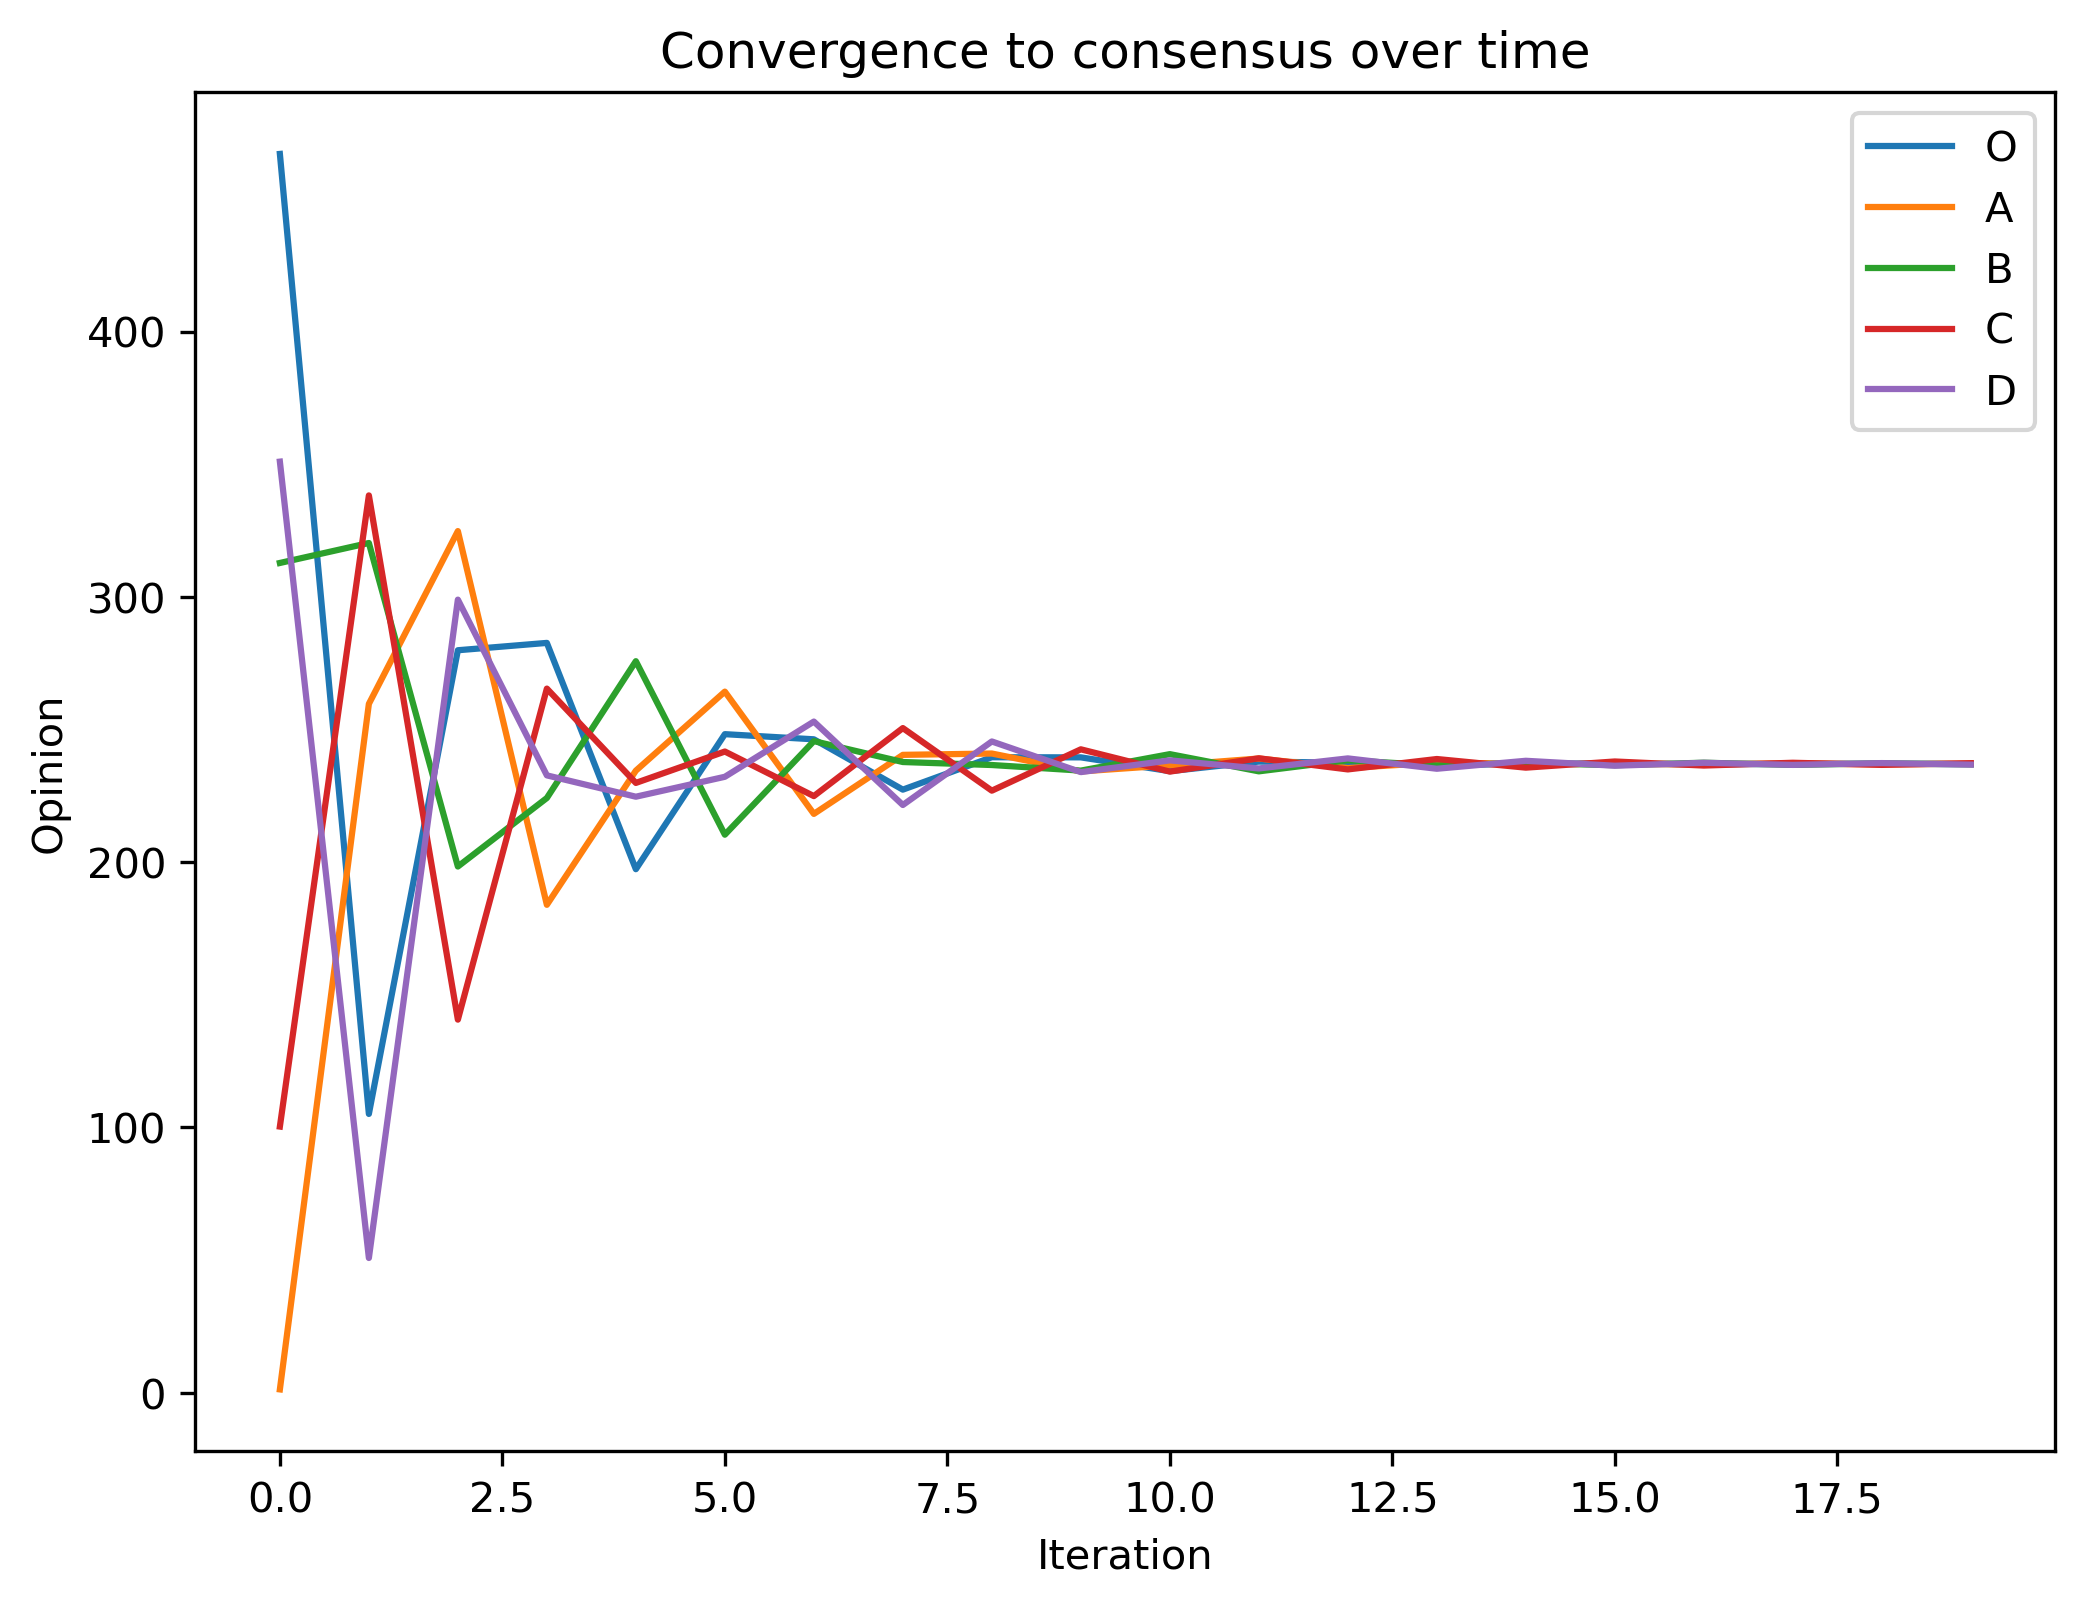

In [11]:
len_r = 20

plt.figure(figsize=(8, 6), dpi=300) 
plt.plot(list(range(len_r)),res_o, label = 'O')
plt.plot(list(range(len_r)),res_a, label = 'A')
plt.plot(list(range(len_r)),res_b, label = 'B')
plt.plot(list(range(len_r)),res_c, label = 'C')
plt.plot(list(range(len_r)),res_d, label = 'D')

plt.title('Convergence to consensus over time')
plt.xlabel('Iteration')
plt.ylabel('Opinion')
plt.legend()
plt.savefig('plots/ex1_conv')

# (f) Assume that the initial state of the dynamics for each node i ∈ V is given by xi(0) = ξi, where {ξi}i∈V are independent random variables with variance σa2 =σb2 =σc2 =1, σo2 =σd2 =2 Compute the variance of the consensus value, and compare your results with the numerical simulations.


In [12]:
simulation = []
for i in tqdm(range(3000)):
    x_0 = [np.random.normal(0,np.sqrt(2)), np.random.normal(0,1),np.random.normal(0,1),np.random.normal(0,1),np.random.normal(0,np.sqrt(2))]
    for n in range(1000):
        x_0 = P @ x_0
    simulation.append(x_0[0])

print(f"Numerical Consensus Variance: {np.var(simulation):.3f}")


100%|██████████| 3000/3000 [00:03<00:00, 850.11it/s]

Numerical Consensus Variance: 0.259


In [13]:
pi_2 = pi**2
print(f"Analytic Consensus Variance:{2*(pi_2[0]+pi_2[4])+(pi_2[1]+pi_2[2]+pi_2[3]):.3f} ")


Analytic Consensus Variance:0.259 


# (g) Remove the edges (d,a) and (d,c). Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition x(0)? Assume that the initial state of the dynamics for each node i ∈ V is given by xi(0) = ξi, where {ξi}i∈V are i.i.d. random variables with variance σ2. Compute analytically the variance of the consensus value.


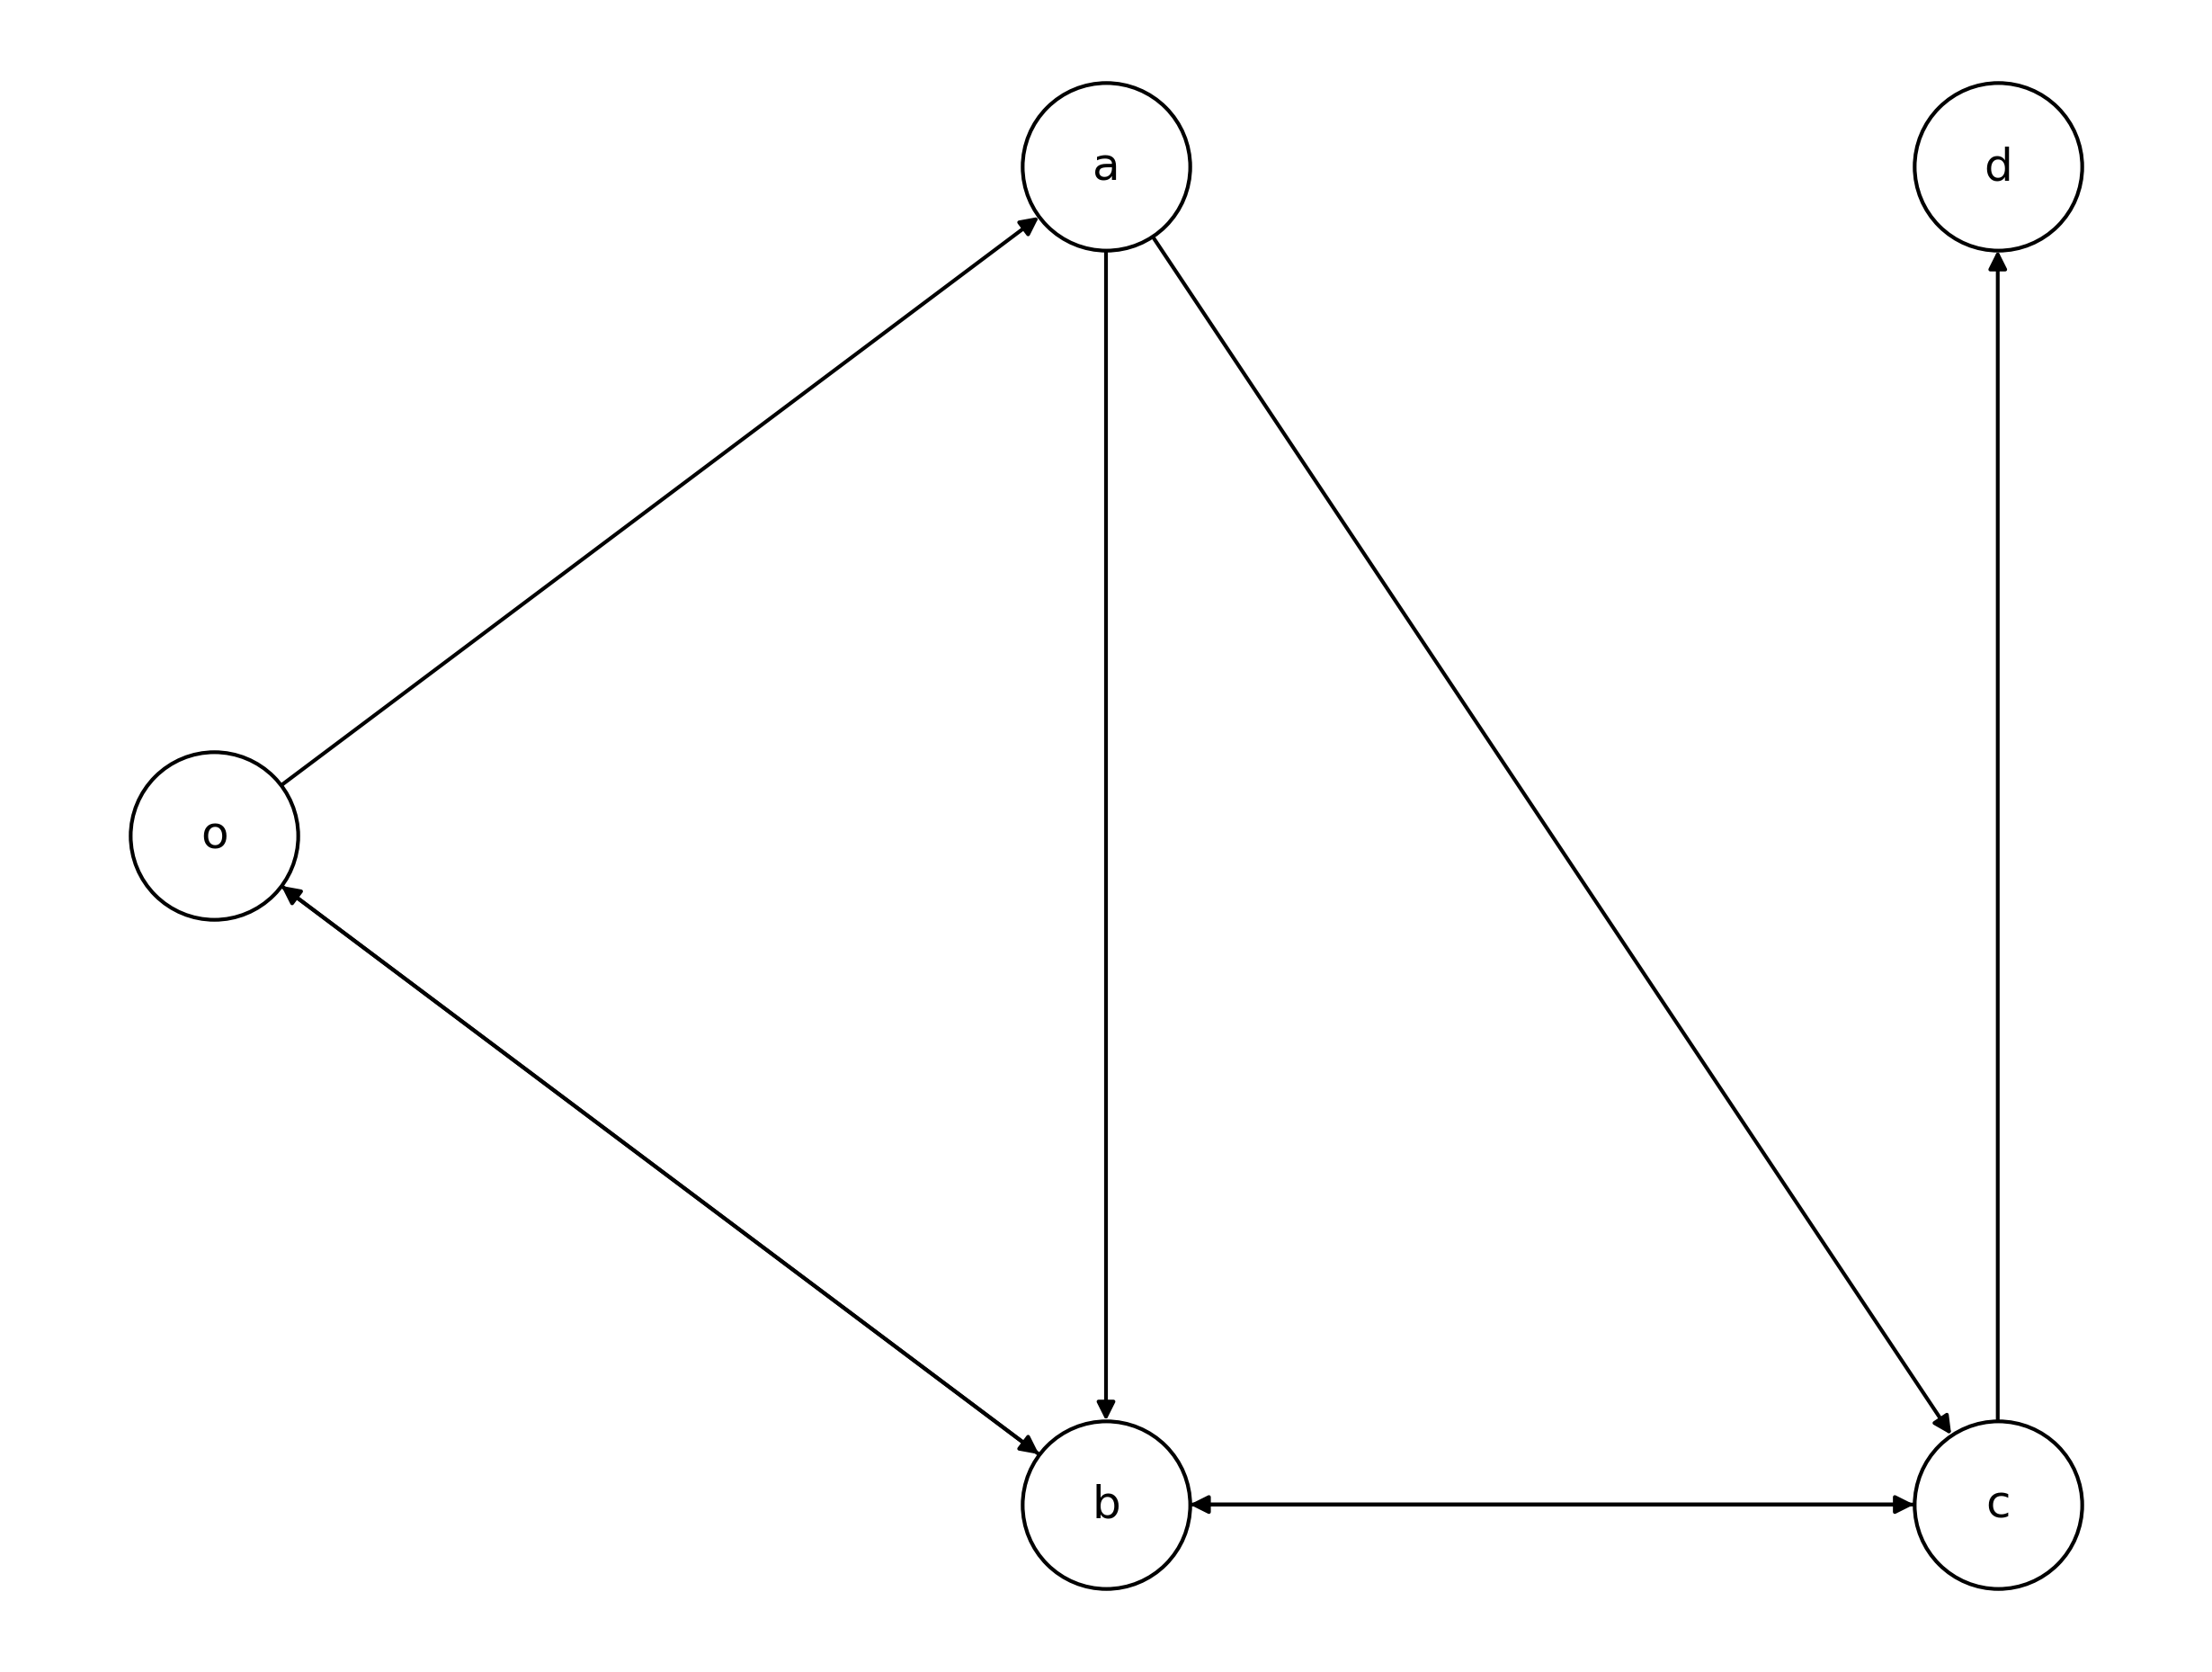

In [14]:
t_rate = np.array([
        [0, 2/5, 1/5, 0, 0],
        [0, 0, 3/4, 1/4, 0],
        [1/2, 0, 0, 1/3, 0],
        [0, 0, 1/3, 0, 2/3],
        [0, 0, 0, 0, 1]
    ])
nodes = ["o", "a", "b", "c", "d"]
node_index = {
    node: idx for idx, node in enumerate(nodes)
}
G = nx.DiGraph()
G.add_nodes_from(nodes)
for i in G.nodes:
    for j in G.nodes:
        if node_index[i] != node_index[j] and t_rate[node_index[i], node_index[j]] > 0:
            G.add_edge(i, j, weight=t_rate[node_index[i], node_index[j]])

pos = {"o":(0,0), "a":(1,1), "b":(1,-1), "c":(2,-1), "d":(2,1)}

plt.figure(figsize=(8, 6), dpi=300) 

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="white",edgecolors='black',  edge_color="black")
plt.savefig('plots/ex1_7.png')

plt.show()


In [15]:
omega = np.sum(t_rate, axis=1).reshape((5,1))
P = t_rate/omega
w,v = np.linalg.eig(P.T)
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real 
    pi = pi/np.sum(pi)
    print("pi", index, "=", pi)

# initial condition
x = [50, 1, 1, 1, 30]

for n in range(1000):
    x = P @ x
print("x(1000):", x)


pi 0 = [0. 0. 0. 0. 1.]
x(1000): [30. 30. 30. 30. 30.]


In [16]:
variance = 4
simulation = []
for i in tqdm(range(3000)):
    x_0 = [np.random.normal(0,np.sqrt(variance)), np.random.normal(0,np.sqrt(variance)),np.random.normal(0,np.sqrt(variance)),
           np.random.normal(0,np.sqrt(variance)),np.random.normal(0,np.sqrt(variance))]
    for n in range(1000):
        x_0 = P @ x_0
    simulation.append(x_0[0])

print(f"Numerical Consensus Variance: {np.var(simulation):.2f}")
pi_2 = pi**2
print(f"Analytic Consensus Variance:{variance*sum(pi_2)} ")



100%|██████████| 3000/3000 [00:03<00:00, 850.38it/s]

Numerical Consensus Variance: 3.90
Analytic Consensus Variance:4.0 


# (h) Consider the graph (V , E , Λ), and remove the edges (c, b) and (d, a). Analyse the French- DeGroot dynamics on the new graph. In particular, describe how the asymptotic behaviour of the dynamics varies in terms of the initial condition x(0), and motivate your answer.


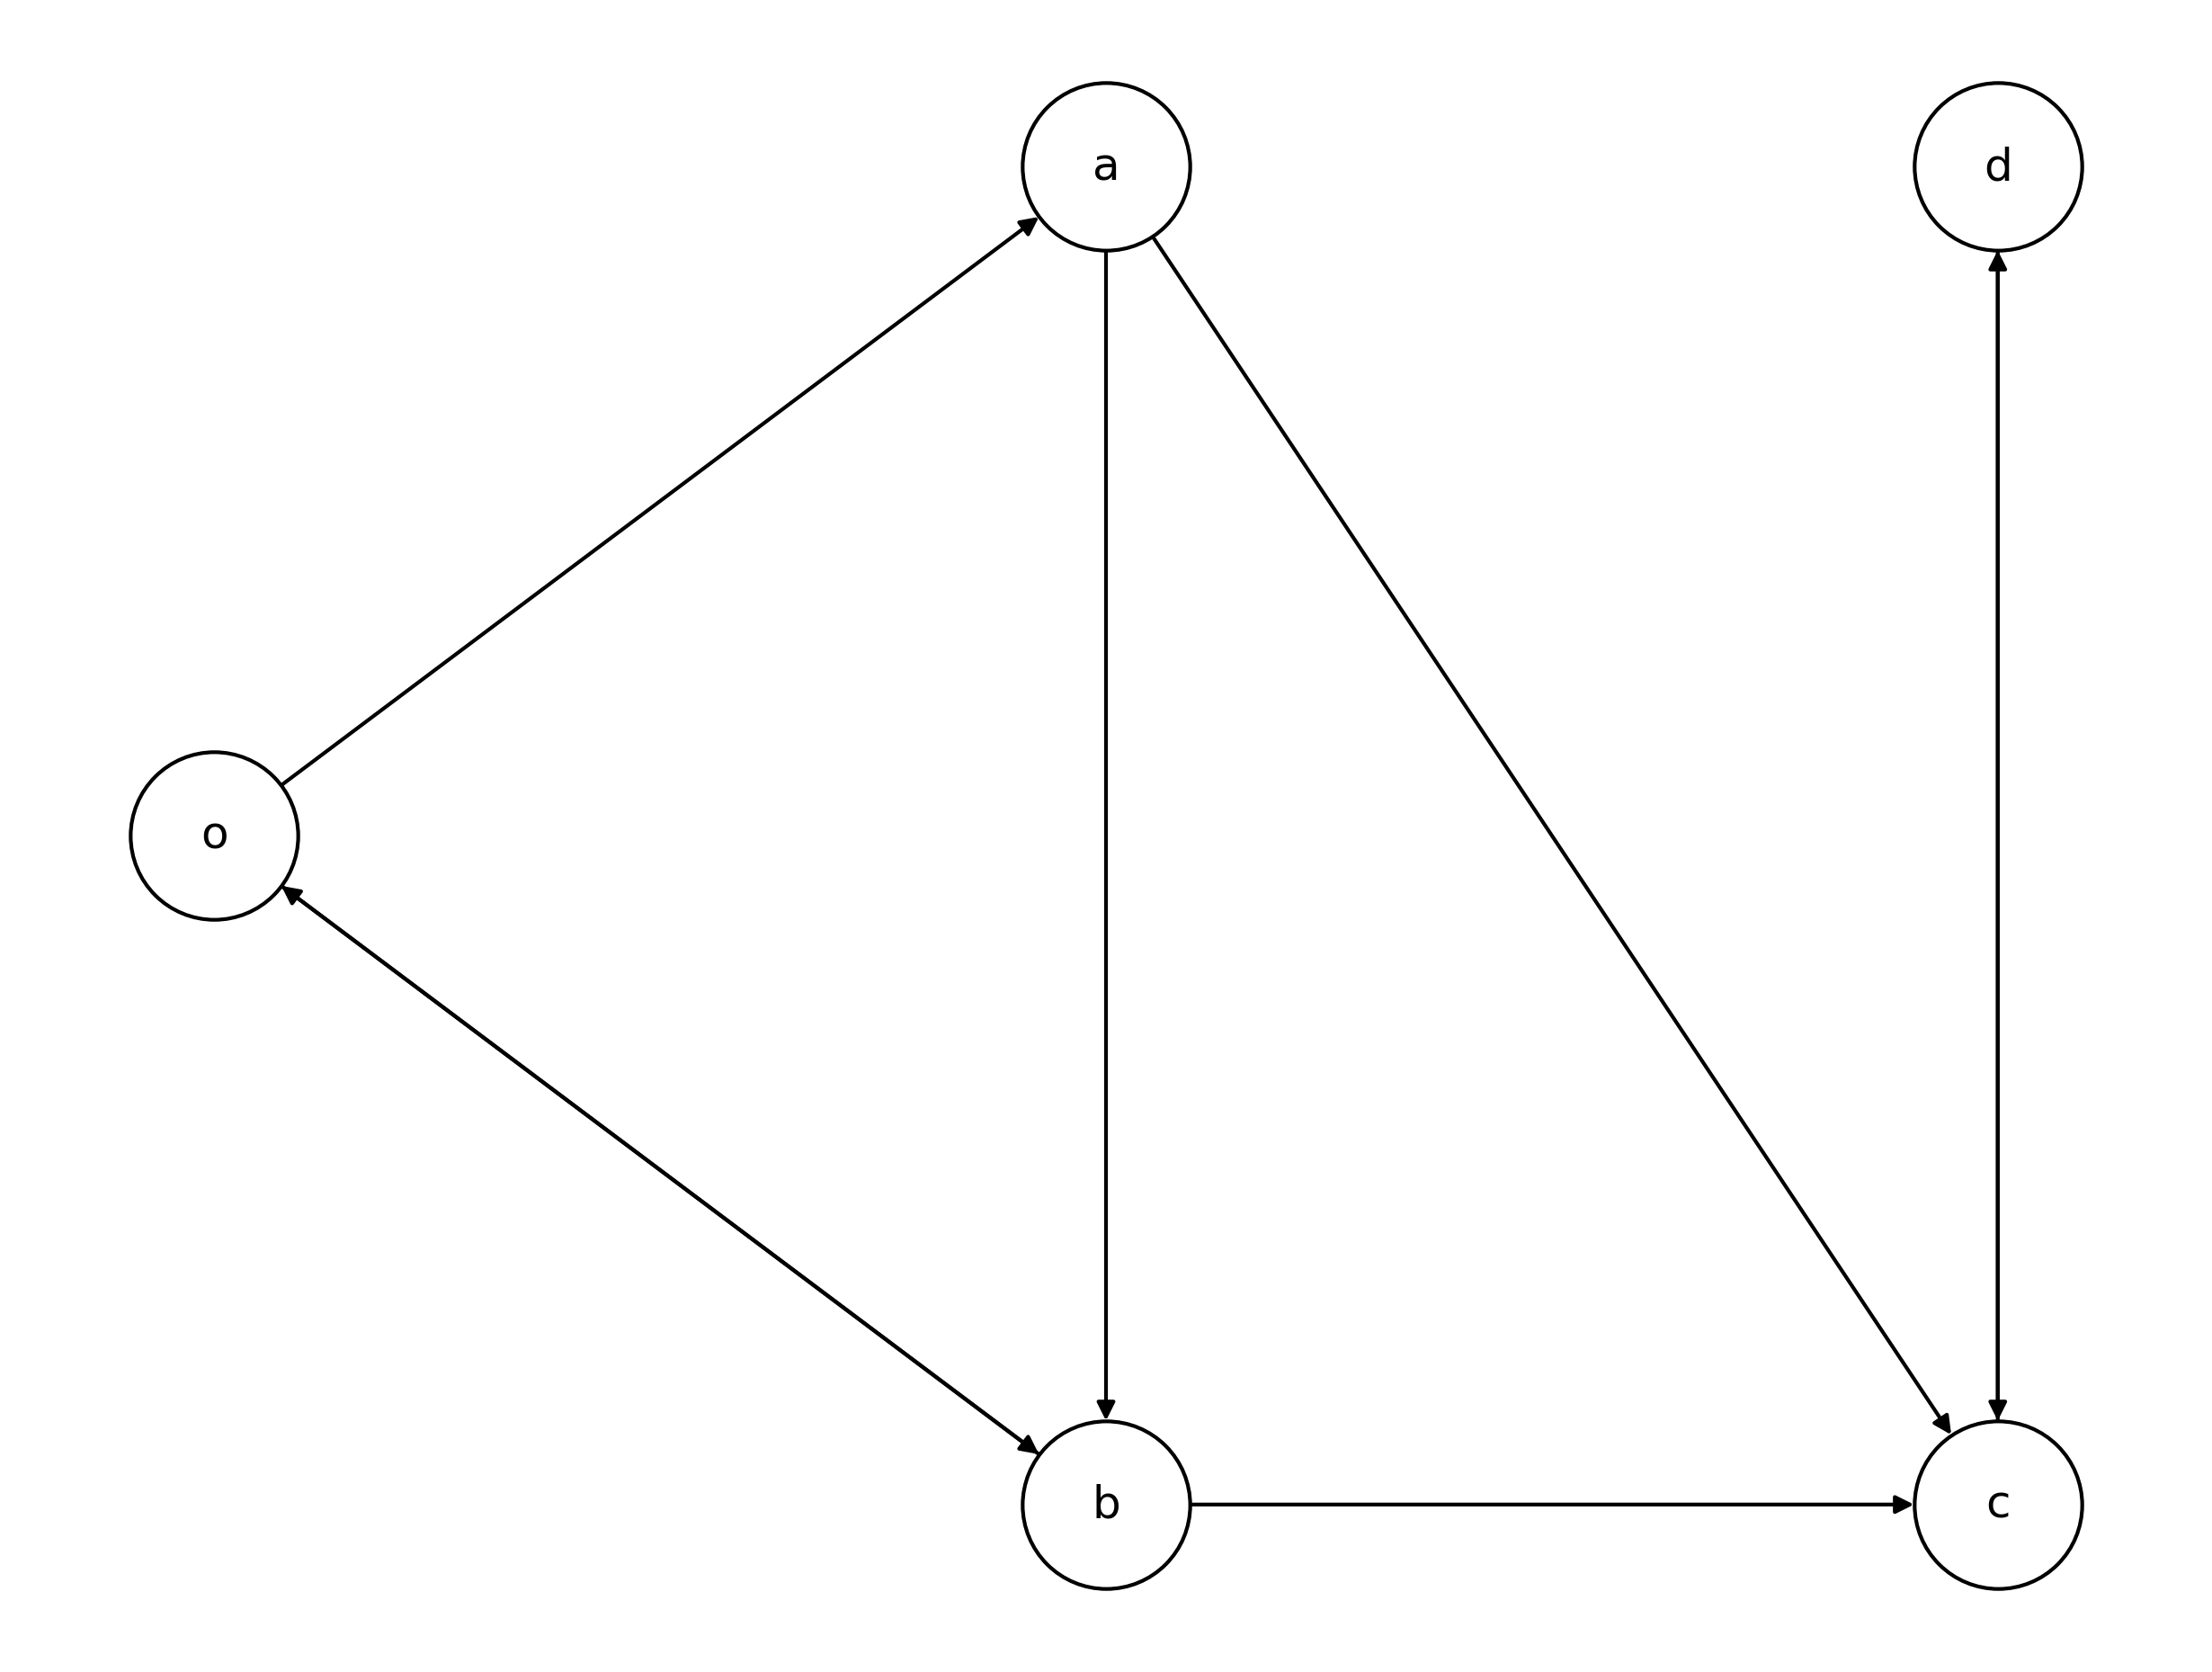

In [17]:
t_rate = np.array([
        [0, 2/5, 1/5, 0, 0],
        [0, 0, 3/4, 1/4, 0],
        [1/2, 0, 0, 1/3, 0],
        [0, 0, 0, 0, 2/3],
        [0, 0, 0, 1/3, 0]
    ])
nodes = ["o", "a", "b", "c", "d"]
node_index = {
    node: idx for idx, node in enumerate(nodes)
}
G = nx.DiGraph()
G.add_nodes_from(nodes)
for i in G.nodes:
    for j in G.nodes:
        if node_index[i] != node_index[j] and t_rate[node_index[i], node_index[j]] > 0:
            G.add_edge(i, j, weight=t_rate[node_index[i], node_index[j]])

            
pos = {"o":(0,0), "a":(1,1), "b":(1,-1), "c":(2,-1), "d":(2,1)}

plt.figure(figsize=(8, 6), dpi=300) 

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="white",edgecolors='black',  edge_color="black")
plt.savefig('plots/ex1_8.png')

plt.show()

In [18]:
omega = np.sum(t_rate, axis=1).reshape((5,1))
P = t_rate/omega
w,v = np.linalg.eig(P.T)
for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
    pi = v[:,index].real  
    pi = pi/np.sum(pi)
    print("pi", index, "=", pi)

# initial condition
x = [33, 70, 0, 25, 40]

res_d = []
res_c = []
res_a = []
res_b = []
res_o = []

for n in range(30):
    x = P @ x
    res_d.append(x[-1])
    res_c.append(x[-2])
    res_o.append(x[0])
    res_a.append(x[1])
    res_b.append(x[2])

print("x(1000):", x)


pi 0 = [-4.90653893e-16 -5.98597750e-16 -1.21682166e-15  5.00000000e-01
  5.00000000e-01]
x(1000): [31.8165342  31.81694092 35.90784972 25.         40.        ]


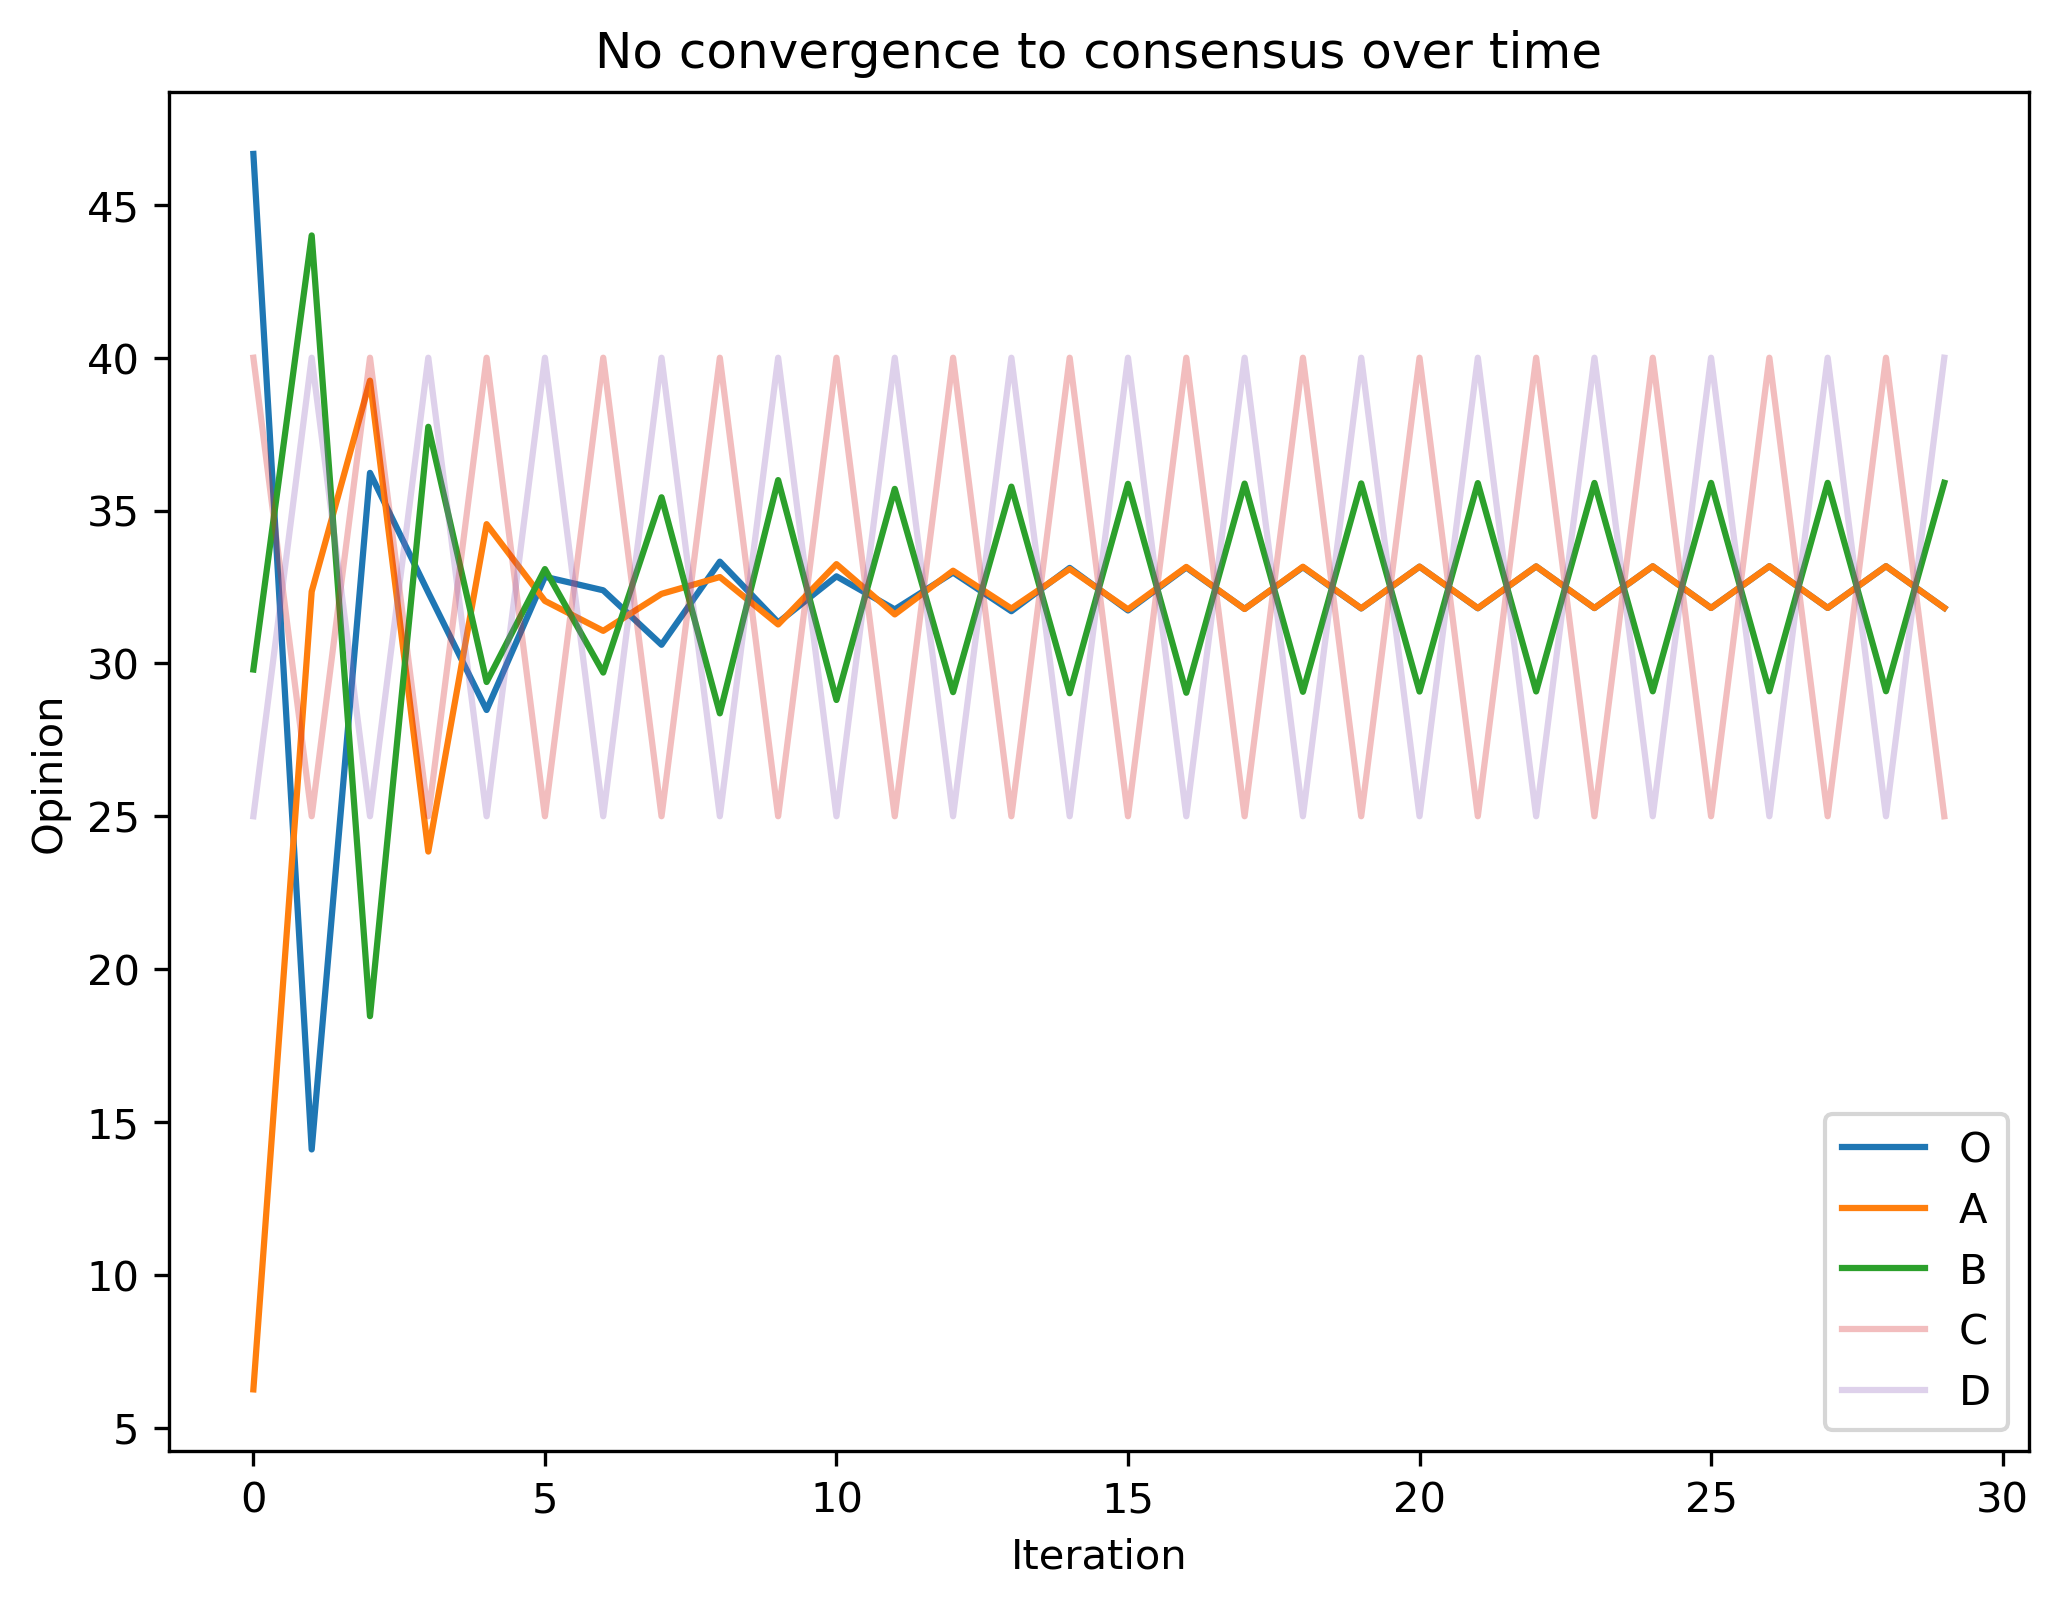

In [19]:
len_r = 30
plt.figure(figsize=(8, 6), dpi=300) 
plt.plot(list(range(len_r)),res_o, label = 'O')
plt.plot(list(range(len_r)),res_a, label = 'A')
plt.plot(list(range(len_r)),res_b, label = 'B')
plt.plot(list(range(len_r)),res_c, alpha = 0.3, label = 'C')
plt.plot(list(range(len_r)),res_d, alpha = 0.3, label = 'D')
plt.title('No convergence to consensus over time')
plt.xlabel('Iteration')
plt.ylabel('Opinion')
plt.legend()
plt.legend()
plt.savefig('plots/ex1_no_conv')
